In [65]:
# !pip install matplotlib-venn

In [66]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import plotly.express as px
import japanize_matplotlib
import numpy as np
from datetime import datetime
import scipy.sparse as sp
from functools import partial

import random
# ランダムに生成す値のシードを固定して再現性を担保する
def seed_everything(seed:int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
sns.set_context("talk")
seed_everything(510)

from typing import List
from contextlib import contextmanager
from time import time

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgbm



In [67]:
# コードの実行時間を計測する便利関数
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [68]:
# --- 1. 全データの読み込み ---
INPUT_DIR = "../"

In [69]:
# 出力のディレクトリを作成
OUTPUT_DIR = "../outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [70]:
# --- 1. 全データの読み込み ---

df_train = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
df_test = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
df_position = pd.read_csv(os.path.join(INPUT_DIR, "position_history.csv"))
df_overtime = pd.read_csv(os.path.join(INPUT_DIR, "overtime_work_by_month.csv"))
df_hr = pd.read_csv(os.path.join(INPUT_DIR, "hr.csv"))
df_dx = pd.read_csv(os.path.join(INPUT_DIR, "dx.csv"))
df_udemy = pd.read_csv(os.path.join(INPUT_DIR, "udemy_activity.csv"))
df_career = pd.read_csv(os.path.join(INPUT_DIR, "career.csv"), encoding='utf-8-sig')


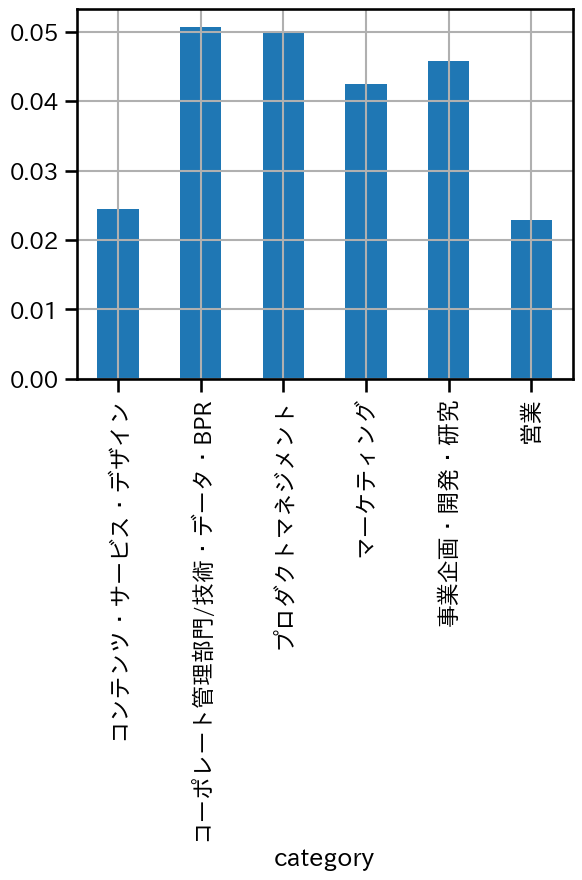

In [71]:
# 初手の可視化は目的変数から。目的変数がどのくらいの頻度で出てきているのか
ax = df_train.groupby("category")["target"].mean().plot(kind="bar")
ax.grid()

目的変数の可視化から、ポジティブデータが全体の2～5％ととても少ないことが分かる


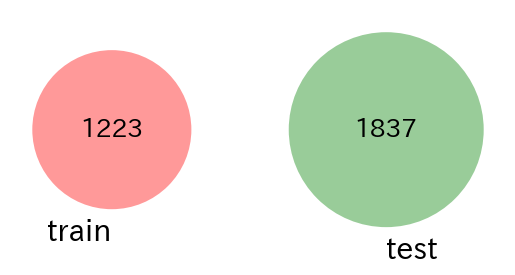

In [72]:
# データの重なりの可視化
# trainデータとtestデータで社員に重なりが無いかを確認
venn2(subsets=(set(df_train["社員番号"].unique()), set(df_test["社員番号"].unique())), set_labels=("train", "test"))

trainデータとtestデータで社員に重なりが無いことが分かる。

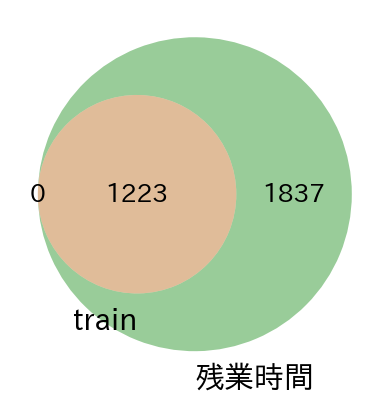

In [73]:
# 残業時間ごとに応募カテゴリの応募率はどうなっているのか？ベン図を書いてみる
venn2(subsets=(set(df_train["社員番号"].unique()), set(df_overtime["社員番号"].unique())), set_labels=("train", "残業時間"))


残業時間が無いようなtrainデータは無い。
残業時間の欠損が無いので、より機械学習に使いやすい。

他のベン図も作ってみる

C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_25960\1820460831.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  z= df_train.groupby([hours, "category"])["target"].mean().unstack()


<Axes: xlabel='category', ylabel='社員番号'>

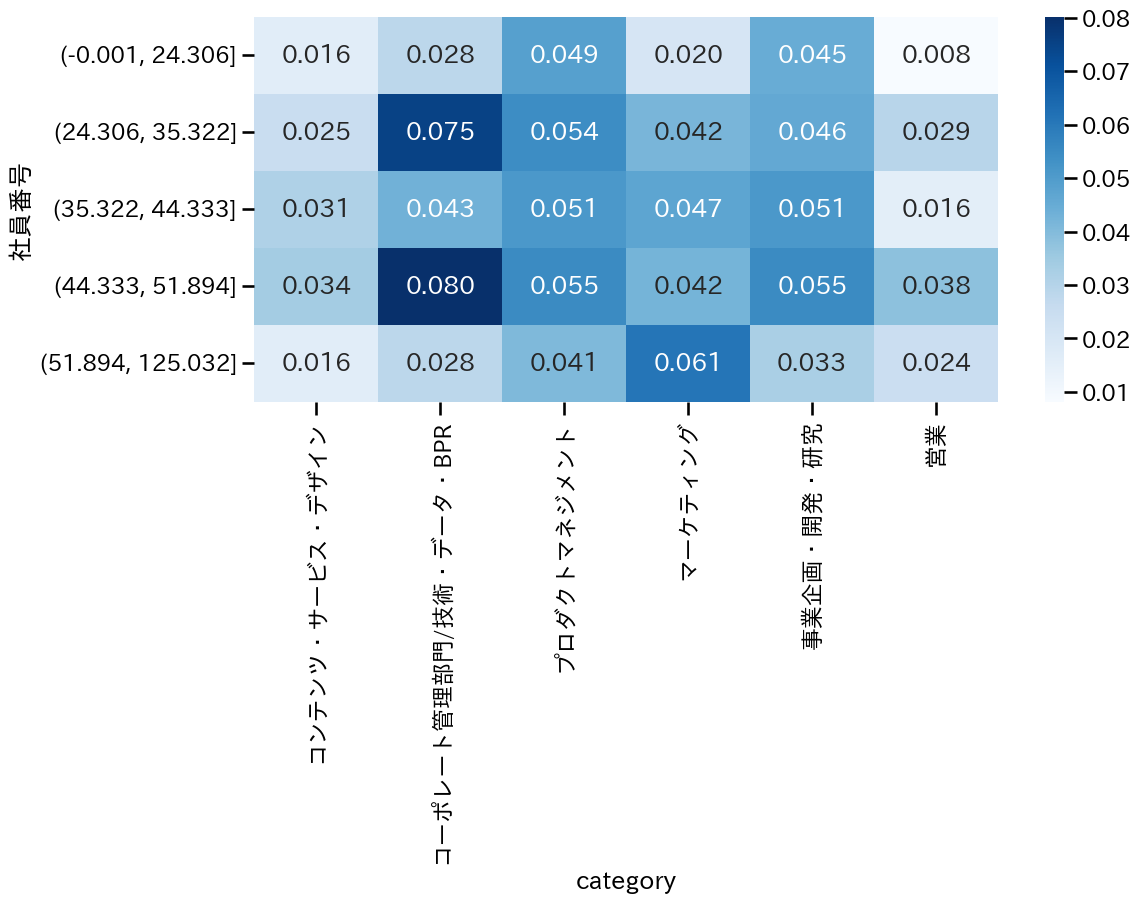

In [74]:
# 社員ごとに平均残業時間を求める
mean_hours_by_workers = df_overtime.groupby("社員番号")["hours"].mean()

# q-cutはquantile cutの略で、連続地を書く幅が同じくらいのデータになるように区切ってくれる
mean_hours_by_workers = pd.qcut(mean_hours_by_workers, q=5)
hours =df_train["社員番号"].map(mean_hours_by_workers)

# 縦軸が1人当たりの残業時間となる
z= df_train.groupby([hours, "category"])["target"].mean().unstack()

fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(z, cmap="Blues", annot=True, fmt=".3f", ax=ax)

社員ごとの残業時間の可視化により、
・マーケティングは残業時間が増えると公募が増える
・PdMや事業企画は残業時間に関わらず。
・コンテンツや営業は真ん中にピークがある
・コーポレートは真ん中にピークがある。
中程度の残業時間を持っている人が公募に手を上げやすい

特徴量エンジニアリング：df_position


In [75]:
# 社員番号の年度の最大から最小を引くと在籍年数になる
df_position_working_years = df_position.groupby("社員番号")["year"].max() - df_position.groupby("社員番号")["year"].min()
print(df_position_working_years)

# 在籍年数をあらたな特徴量とする関数を作成
def merge_by_worker_id(left, right):
    return pd.merge(left["社員番号"], right, on="社員番号", how="left").drop(columns=["社員番号"])


社員番号
-1sqs0GXzpPJuAVKHUUFgg==    2
-2Sq3E0WkZj8pL7jxdL3Cg==    1
-4jh26kLzkU8JFQwdeQU9w==    2
-4taxxVbT1nU-J5fHWmDfQ==    2
-5W_JQCSTAYe2gGJMuT4_w==    2
                           ..
zuplFpzBoM4c1dFy5HPXqg==    2
zwcjIiu_sqUs8akLOfuYKA==    2
zxPKKLM85QljzRfp0yisow==    2
zxY0Eflwm1tYj1Wt6vo_1g==    2
zxmtr2h4ypvsNq02K9AMJg==    2
Name: year, Length: 3060, dtype: int64


In [76]:
# 社員番号の役職のユニーク数を数えれば、役職が変化した人がいる
# 1ならずっと同じ役職。3なら年度ごとに全部違う役職
df_position_position_count= df_position.groupby("社員番号")["役職"].nunique()
print(df_position_position_count)

# 役職の変化を新たな特徴量として追加
# aggはagrigationで集約情報という意味
# 働いている年数とポジションを変えた年数は何回あるかを集計する関数
def create_positon_aggregation_feture(input_df):
    agg = pd.concat([
        (df_position.groupby("社員番号")["year"].max() - df_position.groupby("社員番号")["year"].min()),
        df_position.groupby("社員番号")["役職"].nunique().rename("change_positon_count")
    ], axis=1)

    return merge_by_worker_id(input_df, agg)

create_positon_aggregation_feture(df_train)

社員番号
-1sqs0GXzpPJuAVKHUUFgg==    2
-2Sq3E0WkZj8pL7jxdL3Cg==    1
-4jh26kLzkU8JFQwdeQU9w==    1
-4taxxVbT1nU-J5fHWmDfQ==    1
-5W_JQCSTAYe2gGJMuT4_w==    1
                           ..
zuplFpzBoM4c1dFy5HPXqg==    1
zwcjIiu_sqUs8akLOfuYKA==    2
zxPKKLM85QljzRfp0yisow==    1
zxY0Eflwm1tYj1Wt6vo_1g==    1
zxmtr2h4ypvsNq02K9AMJg==    1
Name: 役職, Length: 3060, dtype: int64


,year,change_positon_count
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
7333,2,1
7334,2,1
7335,2,1
7336,2,1


In [77]:
# 役職の最終年度の24年度の役職のみを取り出す（lastを使う）
# アンダーバーは一時的な変数を定義するときに付けることが多い
_df = df_position.groupby("社員番号").last()
print(_df)
def create_career_one_hot_encoding_feature(input_df):
    column_name = "役職"
    unique_values = df_position[column_name].unique()
    _df = df_position.groupby("社員番号").last()

    # 役職をカテゴリにする
    cat_series = pd.Categorical(_df[column_name], categories=unique_values)
    df_dummy = pd.get_dummies(cat_series, prefix=column_name)

    df_dummy.columns = df_dummy.columns.tolist()
    df_dummy["社員番号"] = _df.index

    return merge_by_worker_id(input_df, df_dummy)



print("---ワンホットエンコーディング実施---")
df_dummy = create_career_one_hot_encoding_feature(df_train)


                          year      勤務区分        役職
社員番号                                              
-1sqs0GXzpPJuAVKHUUFgg==    24       正社員  グループリーダー
-2Sq3E0WkZj8pL7jxdL3Cg==    24       正社員        一般
-4jh26kLzkU8JFQwdeQU9w==    24  正社員(管理職)        課長
-4taxxVbT1nU-J5fHWmDfQ==    24       正社員        一般
-5W_JQCSTAYe2gGJMuT4_w==    24       正社員        一般
...                        ...       ...       ...
zuplFpzBoM4c1dFy5HPXqg==    24       正社員        一般
zwcjIiu_sqUs8akLOfuYKA==    24  正社員(管理職)        部長
zxPKKLM85QljzRfp0yisow==    24       正社員        一般
zxY0Eflwm1tYj1Wt6vo_1g==    24       正社員        一般
zxmtr2h4ypvsNq02K9AMJg==    24       正社員        一般

[3060 rows x 3 columns]
---ワンホットエンコーディング実施---


<bound method _AxesBase.grid of <Axes: >>

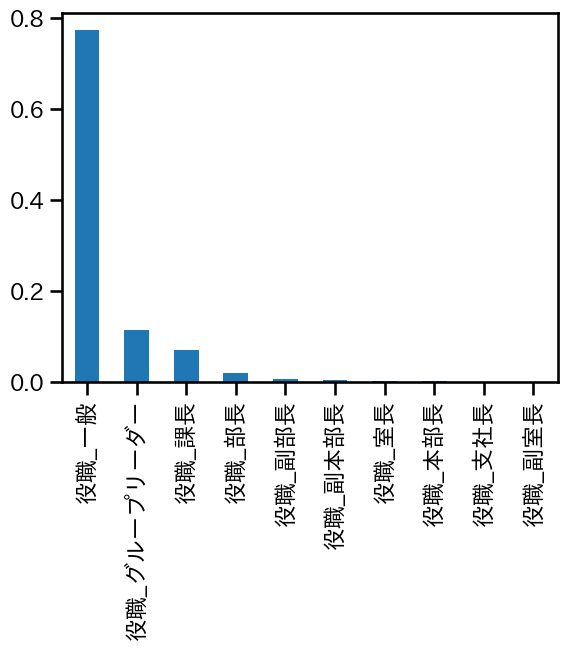

In [78]:
# ワンホットエンコーディング後の分布
ax = df_dummy.mean().plot(kind="bar")
ax.grid

In [79]:
# 

# この関数は、input_df という名前でPandasのデータフレーム (pd.DataFrame) を受け取ります
def create_category_one_hot_encoding_feture(input_df: pd.DataFrame):
    # 列の名前 ("category") を、column_name という変数に格納
    column_name = "category"
    # input_df データフレームから category 列（input_df[column_name]）を取り出し、
    # .unique() を使って重複しないカテゴリの種類をすべてリストアップ
    unique_values = input_df[column_name].unique()
    # category 列をカテゴリ型データに変換しています。
    # categories=unique_values と指定することで、カテゴリの順序を unique_values の順番に固定
    cat_series = pd.Categorical(input_df[column_name], categories=unique_values)
    # カテゴリ型のデータ (cat_series) を受け取り、ワンホットエンコーディングを実行
    df_dummy = pd.get_dummies(cat_series, prefix=column_name)
    # データフレームの列名（df_dummy.columns）を一度リスト形式に変換し、
    # それを再度列名として設定し直しています。必須ではありません。
    df_dummy.columns = df_dummy.columns.tolist()
    
    return df_dummy

create_category_one_hot_encoding_feture(df_train)

,category_コンテンツ・サービス・デザイン,category_コーポレート管理部門/技術・データ・BPR,category_プロダクトマネジメント,category_マーケティング,category_事業企画・開発・研究,category_営業
0,True,False,False,False,False,False
1,False,True,False,False,False,False
2,False,False,True,False,False,False
3,False,False,False,True,False,False
4,False,False,False,False,True,False
...,...,...,...,...,...,...
7333,False,True,False,False,False,False
7334,False,False,True,False,False,False
7335,False,False,False,True,False,False
7336,False,False,False,False,True,False


## career.csvのアンケート結果のデータ加工

In [80]:
# career.csvの加工
import re

# データの読み込み
df_career = pd.read_csv(os.path.join(INPUT_DIR, "career.csv"), encoding='utf-8-sig')

# 最初に、すべてのカラム名から前後の空白と改行文字を削除します
df_career.columns = df_career.columns.str.strip()

# 回答の文字列から先頭の数字を抽出する関数
def extract_score(value):
    # 値が文字列でない場合（例: 空白）も考慮
    if not isinstance(value, str):
        return np.nan
    
    # 正規表現で文字列の先頭にある数字（\d）を検索
    match = re.search(r'^\d', value.strip())
    
    if match:
        # 数字が見つかった場合、整数に変換して返す
        return int(match.group(0))
    else:
        # 数字が見つからない場合はNaN（欠損値）を返す
        return np.nan

# 社員番号以外のすべての列に関数を適用
# df_career.columns[1:] は「1列目以降のすべての列」という意味
for col in df_career.columns[1:]:
    df_career[col] = df_career[col].apply(extract_score)

# スコアを反転させるカラムのリスト
reverse_cols = [
    "自分のこれからのキャリアには、あまり関心がない\n",
    "これからのキャリアをどう歩むべきか、あまり考えていない\n",
    "納得いくキャリアを歩めない原因の大半は周囲の環境にある\n",
    "キャリアは周りの環境によって決められていくものだと思う\n"
]

# カラム名に改行文字が含まれていると表示が崩れることがあるため、
# 表示用に改行を削除したカラム名のリストを作成
display_cols = [col.strip() for col in reverse_cols]
# 元のデータフレームのカラム名も一時的に修正
df_career.columns = [col.strip() if col in reverse_cols else col for col in df_career.columns]


print("--- 🔢 スコア反転前のデータ ---")
print(df_career[display_cols].head())

# 対象となる各カラムのスコアを反転させる
for col in display_cols:
    if col in df_career.columns:
        df_career[col] = 6 - df_career[col]
    else:
        print(f"警告: カラム '{col.strip()}' が見つかりませんでした。")

print("\n" + "="*50 + "\n")

print("--- 🔄 スコア反転後のデータ ---")
print(df_career[display_cols].head())

# 処理後のデータを確認
print("--- 全ての処理が完了した後のデータ ---")
print(df_career.head())

# 各カテゴリに属するカラム名のリストを定義
feature_groups = {
    "職業的自己イメージの明確さ": [
        "自分の能力を発揮できる仕事上の得意分野が見つかっている",
        "自分はどんな仕事をやりたいのか明らかである",
        "自分は何を望んで今の仕事をしているのかわかっている",
        "自分なりの職業的な生き方に関する目標・目的がはっきりしている"
    ],
    "主体的キャリア形成意欲": [
        "自分のこれからのキャリアには、あまり関心がない",
        "これからのキャリアを、より充実したものにしたいと強く思う",
        "キャリア設計（職業生活の設計）は、自分にとって重要な課題である",
        "これからのキャリアをどう歩むべきか、あまり考えていない"
    ],
    "キャリアの自己責任自覚": [
        "納得いくキャリアを歩めるかどうかは、自分の責任だと思う",
        "キャリア形成は、自分自身の責任である",
        "納得いくキャリアを歩めない原因の大半は周囲の環境にある",
        "キャリアは周りの環境によって決められていくものだと思う"
    ],
    "職場環境変化への適応行動": [
        "新しい環境や状況にも、わりあい早くなじんで対応している",
        "職場環境の変化に対して自分なりに考えて対応している",
        "新しい職場に移ってもすぐに自分らしさを発揮している",
        "職場の制度や仕事が変わってもすぐ対応している"
    ],
    "キャリア開発行動": [
        "自分の職種・業界分野における最新動向を常に情報収集している",
        "仕事のために新しいことをいろいろ勉強している",
        "社会・経済の動きや成り行きに関する情報を、積極的に収集している",
        "新しい知識・技術を積極的に学ぶように努めている"
    ],
    "ネットワーク行動": [
        "新しい人間関係が構築できるように、社内外の活動に積極的に参加している",
        "仕事と直接関係ない人とも積極的に交流するようにしている",
        "新しいネットワークづくりに常に取り組んでいる"
    ],
    "主体的仕事行動": [
        "自分の満足感を高めるように、仕事のやり方を工夫している",
        "常に自発的に仕事を行っている",
        "自分の価値観やポリシーを持って仕事に取り組んでいる",
        "仕事の進め方や企画を立てる上で、今までの延長上のやり方ではなく、自分なりの発想を持って取り組んでいる"
    ]
}

# 新しい合計点のカラムを作成
for new_col_name, group_cols in feature_groups.items():
    # .sum(axis=1) で行ごとに合計点を計算
    df_career[new_col_name] = df_career[group_cols].sum(axis=1, min_count=1) # 1つでも有効な値があれば合計


# --- Step 3: 結果の確認 ---
print("--- 作成された新しい特徴量（合計点） ---")

# 作成した新しいカラム名だけのリスト
new_feature_columns = list(feature_groups.keys())
# 社員番号と新しいカラムだけを表示
print(df_career[["社員番号"] + new_feature_columns].head())


--- 🔢 スコア反転前のデータ ---
   自分のこれからのキャリアには、あまり関心がない  これからのキャリアをどう歩むべきか、あまり考えていない  \
0                        4                            3   
1                        1                            1   
2                        1                            1   
3                        5                            1   
4                        2                            2   

   納得いくキャリアを歩めない原因の大半は周囲の環境にある  キャリアは周りの環境によって決められていくものだと思う  
0                            3                            5  
1                            1                            1  
2                            1                            1  
3                            1                            1  
4                            1                            2  


--- 🔄 スコア反転後のデータ ---
   自分のこれからのキャリアには、あまり関心がない  これからのキャリアをどう歩むべきか、あまり考えていない  \
0                        2                            3   
1                        5                            5   
2                        5                          

In [81]:
# create_career_summary_feature という関数を作成(上記と同じ処理)
def create_career_summary_feature(input_df: pd.DataFrame, career_csv_path: str):
    """
    career.csvを読み込み、スコアの抽出、逆転項目の処理、
    カテゴリごとの合計点の算出を行い、input_dfに結合して返す関数
    """
    # --- Step 1: career.csvの読み込みと前処理 ---
    try:
        df_career = pd.read_csv(career_csv_path, encoding='utf-8-sig')
    except FileNotFoundError:
        print(f"'{career_csv_path}' が見つかりません。処理をスキップします。")
        return input_df # ファイルがない場合は元のdfをそのまま返す

    df_career.columns = df_career.columns.str.strip()

    def extract_score(value):
        if not isinstance(value, str): return np.nan
        match = re.search(r'\d', value)
        if match: return int(match.group(0))
        else: return np.nan

    for col in df_career.columns[1:]:
        df_career[col] = df_career[col].apply(extract_score)

    reverse_cols = [
        "自分のこれからのキャリアには、あまり関心がない", "これからのキャリアをどう歩むべきか、あまり考えていない",
        "納得いくキャリアを歩めない原因の大半は周囲の環境にある", "キャリアは周りの環境によって決められていくものだと思う"
    ]
    for col in reverse_cols:
        if col in df_career.columns:
            df_career[col] = 6 - df_career[col]

    # --- Step 2: 指定された項目を合計して新しい特徴量を作成 ---
    feature_groups = {
        "職業的自己イメージの明確さ": ["自分の能力を発揮できる仕事上の得意分野が見つかっている", "自分はどんな仕事をやりたいのか明らかである", "自分は何を望んで今の仕事をしているのかわかっている", "自分なりの職業的な生き方に関する目標・目的がはっきりしている"],
        "主体的キャリア形成意欲": ["自分のこれからのキャリアには、あまり関心がない", "これからのキャリアを、より充実したものにしたいと強く思う", "キャリア設計（職業生活の設計）は、自分にとって重要な課題である", "これからのキャリアをどう歩むべきか、あまり考えていない"],
        "キャリアの自己責任自覚": ["納得いくキャリアを歩めるかどうかは、自分の責任だと思う", "キャリア形成は、自分自身の責任である", "納得いくキャリアを歩めない原因の大半は周囲の環境にある", "キャリアは周りの環境によって決められていくものだと思う"],
        "職場環境変化への適応行動": ["新しい環境や状況にも、わりあい早くなじんで対応している", "職場環境の変化に対して自分なりに考えて対応している", "新しい職場に移ってもすぐに自分らしさを発揮している", "職場の制度や仕事が変わってもすぐ対応している"],
        "キャリア開発行動": ["自分の職種・業界分野における最新動向を常に情報収集している", "仕事のために新しいことをいろいろ勉強している", "社会・経済の動きや成り行きに関する情報を、積極的に収集している", "新しい知識・技術を積極的に学ぶように努めている"],
        "ネットワーク行動": ["新しい人間関係が構築できるように、社内外の活動に積極的に参加している", "仕事と直接関係ない人とも積極的に交流するようにしている", "新しいネットワークづくりに常に取り組んでいる"],
        "主的仕事行動": ["自分の満足感を高めるように、仕事のやり方を工夫している", "常に自発的に仕事を行っている", "自分の価値観やポリシーを持って仕事に取り組んでいる", "仕事の進め方や企画を立てる上で、今までの延長上のやり方ではなく、自分なりの発想を持って取り組んでいる"]
    }

    new_feature_columns = list(feature_groups.keys())
    for new_col_name, group_cols in feature_groups.items():
        df_career[new_col_name] = df_career[group_cols].sum(axis=1, min_count=1)

    # --- Step 3: input_dfに結合 ---
    # 必要なカラム（社員番号と新しい特徴量）だけを抽出
    df_career_features = df_career[["社員番号"] + new_feature_columns]
    
    # 元のデータフレームに結合して返す
    output_df = pd.merge(input_df, df_career_features, on="社員番号", how="left")
    
    return output_df


career_csv_path = os.path.join(INPUT_DIR, "career.csv")

# partialを使って、career_csv_path引数を固定した新しい関数を作成
create_career_summary_feature_fixed = partial(create_career_summary_feature, career_csv_path=career_csv_path)



## dx.csvのデータ加工

In [82]:
# 「研修カテゴリ」は10の項目がある。これらのうち「実践」が付いているものはスキルが高いのでは？
# 「実践」がつく研修カテゴリのリストを定義します

def create_practical_skill_feature(df):
    """
    dx.csvを読み込み、「実践」スキル保有者の特徴量を作成し、入力のデータフレームにマージする関数
    
    Args:
        df (pd.DataFrame): 特徴量を追加する対象のデータフレーム (例: train_df, test_df)

    Returns:
        pd.DataFrame: 「実践スキル保有」列が追加されたデータフレーム
    """
    # dx.csvファイルを読み込みます
    df_dx = pd.read_csv(os.path.join(INPUT_DIR, "dx.csv"))

    # 「実践」がつく研修カテゴリのリストを定義します
    practical_skill_categories = [
        'システム開発_実践',
        'データ利活用_実践',
        'プロダクト開発_実践'
    ]

    # '研修カテゴリ'がリストに含まれていれば1、そうでなければ0とする'is_practical'列を作成
    df_dx['is_practical'] = df_dx['研修カテゴリ'].isin(practical_skill_categories).astype(int)

    # 社員番号ごとにグループ化し、「実践」研修を受けたことがあれば1となるように集約
    df_practical_skill = df_dx.groupby('社員番号')['is_practical'].max().reset_index()
    df_practical_skill.rename(columns={'is_practical': '実践スキル保有'}, inplace=True)

    # 元のデータフレームに作成した特徴量をマージします
    df = pd.merge(df, df_practical_skill, on='社員番号', how='left')

    # マージの際に該当がなかったデータ (NaN) は0で埋めます
    df['実践スキル保有'] = df['実践スキル保有'].fillna(0).astype(int)

    return df

# 何名くらい「実践」と名の付く研修を受けているかの確認
# train.csvからユニークな社員番号リストでDataFrameを作成
df_train_unique_users = pd.DataFrame(df_train['社員番号'].unique(), columns=['社員番号'])

# 関数を適用
df_processed = create_practical_skill_feature(df_train_unique_users)

# 結果を表示
print("--- 関数適用後のデータフレーム (先頭5行) ---")
print(df_processed.head())
print("\\n" + "="*50 + "\\n")
print("--- 「実践スキル保有」列の内訳 ---")
print(df_processed['実践スキル保有'].value_counts())


--- 関数適用後のデータフレーム (先頭5行) ---
                       社員番号  実践スキル保有
0  -2Sq3E0WkZj8pL7jxdL3Cg==        0
1  -4taxxVbT1nU-J5fHWmDfQ==        0
2  -6LqZqVuZIYsbdzQPYGopw==        0
3  -EtuCRccKFQgi3UfXRvRkA==        0
4  -J_LZatYK7_1pM_11ZOAyw==        0
\n==================================================\n
--- 「実践スキル保有」列の内訳 ---
実践スキル保有
0    1053
1     170
Name: count, dtype: int64


特徴量エンジニアリングを実施したデータフレームを結合する

In [83]:
def build_feature(input_df: pd.DataFrame, feature_functions: List) -> pd.DataFrame:
    # カラのデータフレームを用意
    out_df = pd.DataFrame()
    print("start build feature...")


    # 各特徴生成関数事で
    for func in feature_functions:

        # funcがpartialオブジェクトか、通常の関数かで名前の取得方法を分ける
        if isinstance(func, partial):
            # partialの場合、.func.__name__ で元の関数名を取得
            func_name = func.func.__name__
        else:
            # 通常の関数の場合、.__name__ で名前を取得
            func_name = func.__name__

        with Timer(prefix=f"create {func_name}"):
            # 特徴量を作成
            _df = func(input_df)

        # 横方向axis=1で結合
        out_df = pd.concat([out_df, _df], axis=1)
    return out_df

In [84]:
# 作成した特徴量をfunctionsにまとめる
functions = [
    create_career_one_hot_encoding_feature, # 役職の最終年度の24年度の役職のみを取り出す
    create_positon_aggregation_feture, # 役職の変化 position_history.csv
    create_category_one_hot_encoding_feture,
    create_career_summary_feature_fixed,
    create_practical_skill_feature,#「研修カテゴリ」で「実践」が付いている
]

In [85]:
# functionsをがっちゃんこする
with Timer(prefix="build train..."):
    df_train_feat = build_feature(df_train, feature_functions=functions)

with Timer(prefix="build test..."):
    df_test_feat = build_feature(df_test, feature_functions=functions)


start build feature...
create create_career_one_hot_encoding_feature 0.027[s]
create create_positon_aggregation_feture 0.033[s]
create create_category_one_hot_encoding_feture 0.006[s]
create create_career_summary_feature 0.195[s]
create create_practical_skill_feature 0.060[s]
build train... 0.331[s]
start build feature...
create create_career_one_hot_encoding_feature 0.026[s]
create create_positon_aggregation_feture 0.027[s]
create create_category_one_hot_encoding_feture 0.007[s]
create create_career_summary_feature 0.170[s]
create create_practical_skill_feature 0.054[s]
build test... 0.292[s]


In [86]:
# --- どのカラムが一致していないかを確認 ---

# 各データフレームのカラムをセット（重複のないリスト）として取得
train_cols = set(df_train_feat.columns)
test_cols = set(df_test_feat.columns)

# 学習データにのみ存在するカラムを特定
only_in_train = train_cols - test_cols
if only_in_train:
    print(f"▼ 学習データにのみ存在するカラム ({len(only_in_train)}個):")
    # 見やすいように1つずつ表示
    for col in sorted(list(only_in_train)):
        print(f"  - {col}")
else:
    print("✅ 学習データにのみ存在するカラムはありません。")

print("\n" + "="*50 + "\n")

# テストデータにのみ存在するカラムを特定
only_in_test = test_cols - train_cols
if only_in_test:
    print(f"▼ テストデータにのみ存在するカラム ({len(only_in_test)}個):")
    # 見やすいように1つずつ表示
    for col in sorted(list(only_in_test)):
        print(f"  - {col}")
else:
    print("✅ テストデータにのみ存在するカラムはありません。")

# # trainとtestのカラムが完全に一致していることを確認する。列数がずれていたら分かるようになる。
# assert df_train_feat.columns.equals(df_test_feat.columns)

▼ 学習データにのみ存在するカラム (1個):
  - target


✅ テストデータにのみ存在するカラムはありません。


In [93]:
# モデルの作成(LightGBM)
# 
def fit_lgbm(X,
             y,
             cv,
             params: dict=None,
             verbose: int=50):
    # パラメータがない時は、空のdictで置き換える
    if params is None:
        params = {}
    
    models = []
    n_records = len(X)
    # training data のtargetと同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records, ), dtype=np.float32)

    # ★デバッグ1: 関数に渡された直後のyの形を確認
    print(f"--- fit_lgbm開始: 入力yのshape: {y.shape} ---\n")

    for i, (idx_train, idx_valid) in enumerate(cv):
        # 交差検定。cv instanceで分割する
        # trainingデータをtrain/validに分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]
        
        # ★デバッグ2: fitの直前のy_trainの形を確認（最重要）
        print(f"--- Fold {i+1} ---")
        print(f"    -> fitting直前のy_trainのshape: {y_train.shape}")
        
        # もしy_trainが2次元だったら、最初の5行を表示して中身を見る
        if y_train.ndim > 1:
            print("    -> y_trainの中身 (先頭5行):\n", y_train[:5])


        clf = lgbm.LGBMClassifier(**params)

        with Timer(prefix="fit fold={}".format(i)):
            clf.fit(x_train, y_train,
                    eval_set=[(x_valid, y_valid)],
                    callbacks=[lgbm.callback.early_stopping(stopping_rounds=100),
                        lgbm.log_evaluation(period=verbose),],)

        # 予測確率を出力してもらう
        pred_i =clf.predict_proba(x_valid)
        # outputの形はsape = (n_samples, 2)になっていることに注意する
        y_pred_prob = pred_i[:, 1]

        oof_pred[idx_valid] = y_pred_prob
        models.append(clf)

        # 今回の指標のMAEで計算する
        score = roc_auc_score(y_valid, y_pred_prob, )
        print(f" -fold{i} - {score:.4f}")
    return oof_pred, models

#  モデル学習のための最終的なデータ準備
print("--- モデル学習のデータ準備を開始 ---")

# 1. 安全のため、インデックスをリセットしてズレを解消
#    これにより、0から始まる連番のインデックスが振り直されます。
df_train_feat.reset_index(drop=True, inplace=True)

# 特徴量セットから、答えである 'target' と、グループ分けに使う '社員番号' を安全に抽出
y = df_train_feat['target']
groups = df_train_feat['社員番号']

# 特徴量セット(X)は、数値のみを抽出し、学習に不要な列を削除したものにする
X = df_train_feat.select_dtypes(include=np.number).drop('target', axis=1, errors='ignore')

# テストデータも同様に、数値のみを抽出
X_test = df_test_feat.select_dtypes(include=np.number)

# カラムの整合性を取る（最終確認）
X_test = X_test.reindex(columns=X.columns, fill_value=0)
assert X.columns.equals(X_test.columns)

print(f"✅ 学習に使用する特徴量の数: {X.shape[1]}個")
print("\n--- 学習に使用するカラム名一覧 ---")
# カラム名を見やすく1つずつ出力
for col in X.columns:
    print(f"  - {col}")
print("---------------------------------")

# 5つのバリデーションに分けている
fold = GroupKFold(n_splits=5, )
cv = list(fold.split(X, y, groups=groups)) 

--- モデル学習のデータ準備を開始 ---
✅ 学習に使用する特徴量の数: 10個

--- 学習に使用するカラム名一覧 ---
  - year
  - change_positon_count
  - 職業的自己イメージの明確さ
  - 主体的キャリア形成意欲
  - キャリアの自己責任自覚
  - 職場環境変化への適応行動
  - キャリア開発行動
  - ネットワーク行動
  - 主的仕事行動
  - 実践スキル保有
---------------------------------


IndexError: index 7404 is out of bounds for axis 0 with size 7338

In [88]:
# パラメーター
params = {
    # 目的関数。これの意味で最少となるようなパラメーターを探す
    # 今回は0または1問題なので、よく使われるbinaryを利用
    "objective": "binary",

    # 学習率：小さいほど滑らかな決定領域が作られ、性能向上につながるが時間がかかる
    "learning_rate": .05,

    # 木の最大値：early_stoppingという枠組みで期の数は制御されるようにしているため、大きい値を指定しておく
    "n_estimators": 1000,

    # 特徴重要度計算のロジック
    "importance_type": "gain",
    "random_state": 510,

    # ログを少なめに
    "verbose": -1
}


In [89]:
# yを目的変数'target'の列のみを持つPandas Seriesに修正します
y = y['target']

with Timer(prefix="training..."):
    oof, models = fit_lgbm(
        X=X.values, 
        y=y.values, 
        cv=cv, 
        params=params
    )

# 実行すると-fold0 - 0.6156などと出力される。
# 交差検定毎のスコアを出すことができる。

fit fold=0 0.002[s]
training... 0.006[s]


ValueError: y should be a 1d array, got an array of shape (5868, 2) instead.

In [ ]:
# trainデータを用いてモデルの検証を実施する。
roc_auc_score(df_train["target"], oof)

0.5927982618948625

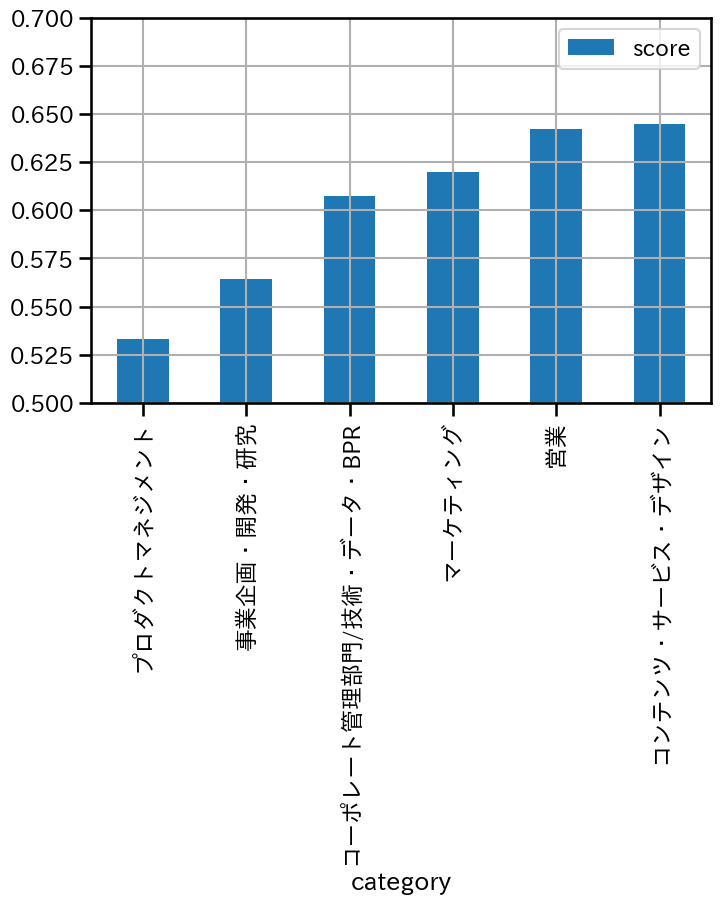

In [ ]:
# 複数のカテゴリごとに応募有無を予測しなくてはならない
# どのカテゴリの予測が難しくて、どのカテゴリの予測が簡単なのかを把握しておくと良い
scores = []
for cat_name, _df in df_train.groupby("category"):
    idx = _df.index
    score_i = roc_auc_score(df_train["target"].iloc[idx], oof[idx])

    scores.append({
        "category": cat_name,
        "score": score_i
    })

fig, ax = plt.subplots(figsize=(8,5))
pd.DataFrame(scores).set_index("category").sort_values("score").plot(kind="bar", ax=ax)
ax.set_ylim([.5, .7])
ax.grid()

# 部署ごとにどのくらい予測があたっているかを確認することができる。
# マーケティングをどうやって予測できるかなどを考えてみる→新たな特徴量を考える

C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_25960\2005055128.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=feature_importance_df,


Text(0.5, 1.0, 'Feature Importance (LightGBM)')

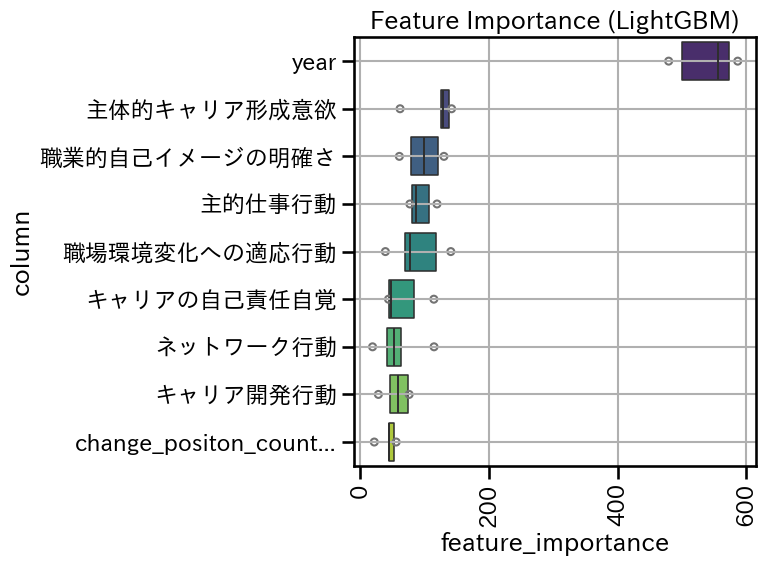

In [ ]:
# 特徴重要度
# 大事な特徴量と大事ではない特徴量を探せる
# LightGBM用の特徴量重要度
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_

        columns = [c if len(c) < 20 else c[:20] + "..." for c in feat_train_df.columns]
        _df["column"] = columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0, ignore_index=True)
    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:50]
    
    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .5)))
    sns.boxenplot(data=feature_importance_df,
                  x="feature_importance",
                  y="column",
                  order=order,
                  ax=ax,
                  palette="viridis",
                  orient="h"
                  )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, X)
ax.set_title("Feature Importance (LightGBM)")

In [ ]:
# 予測ファイルを作る。5こ予測ファイルを作ってその平均でモデルが構築される。
df_submission = pd.DataFrame()

predicts = [model.predict_proba(X_test.values)[:, 1]for model in models]
# 5つのモデルの予測値の平均を取る
predict_avg = np.array(predicts).mean(axis=0)
# 提出用データフレームを作成
df_submission = pd.DataFrame({'target': predict_avg})

# 1. 現在の日時を取得
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M")
filename = f"{timestamp}_submission.csv"

df_submission.to_csv(os.path.join(OUTPUT_DIR, filename),index=False)

In [ ]:
# # --- 2. 各データの集計・加工 ---

# # 応募者データ（ターゲット）の作成
# df_target = df_train.groupby('社員番号')['target'].max().reset_index()

# # 最新の役職データを抽出
# df_position_latest = df_position.sort_values('year').groupby('社員番号').last().reset_index()

# # 残業時間の平均を算出
# df_overtime_avg = df_overtime.groupby('社員番号')['hours'].mean().reset_index()
# df_overtime_avg = df_overtime_avg.rename(columns={'hours': '月平均残業時間'})

# # 研修(hr)の受講回数をカウント
# df_hr_count = df_hr.groupby('社員番号').size().reset_index(name='研修受講回数')

# # DX研修の受講回数をカウント
# df_dx_count = df_dx.groupby('社員番号').size().reset_index(name='DX研修受講回数')

# # Udemyのアクティビティ数をカウント
# df_udemy_count = df_udemy.groupby('社員番号').size().reset_index(name='Udemyアクティビティ数')

# # キャリアアンケートのデータを加工
# # カラム名を短縮 (例: career_q1, career_q2...)
# original_career_columns = df_career.columns.tolist()
# new_career_columns = {col: f'career_q{i}' for i, col in enumerate(original_career_columns)}
# df_career_processed = df_career.rename(columns=new_career_columns)
# df_career_processed = df_career_processed.rename(columns={'career_q0': '社員番号'}) # 社員番号のカラム名は元に戻す

# # 回答の文字列からスコア（数字）を抽出する関数
# def extract_score(value):
#     if isinstance(value, str):
#         match = re.search(r'^(\d)', value.strip())
#         if match:
#             return int(match.group(1))
#     return None # 数値が見つからない場合はNone（欠損値）

# # 社員番号以外の全カラムに適用
# for col in df_career_processed.columns:
#     if col != '社員番号':
#         df_career_processed[col] = df_career_processed[col].apply(extract_score)


